# PRO3342 Modelagem e Simulação de Sistemas de Produção
## Trabalho prático - Grupo 106
### Nome (número USP) em ordem alfabética

1. Edson Sadao Pereira Toyoshima (11807661)
2. Giovane Furlan Magri (11820364)
3. Kevin Kenzo Haneda Goto(11807431)
4. Mateus Henrique Trevensoli Travagin (11807682)
5. Yuichi Tokumoto (10770878)

## **0) Instruções**

- Para executar a simulação, execute as seções **1, 2 e 3**, nesta ordem
- Na seção 3 e na função *set_config* é possível escolher algums parâmetros para a simulação:
  * **Smin**: $\in$ [0, $\infty $[
    * Representa o estoque mínimo que deve ser atingido para que o item comece a ser produzido (pode ser parametrizado com as variáveis fator_stock, fator_demanda_prod1 e fator_demanda_prod2)
  * **Smax**: $\in$ [Smin, $\infty $[
    * Representa o estoque máximo do item (pode ser parametrizado com as variáveis fator_stock, fator_demanda_prod1 e fator_demanda_prod2)
  * **initial_stock**: $\in$ [0, Smax[
    * Representa o estoque inicial do item na simulação (pode ser parametrizado com as variáveis fator_stock, fator_demanda_prod1 e fator_demanda_prod2)
  * **cost_stock**: $\in$ [0, $\infty $[
    * Representa o custo unitário de estoque para o período simulado
  * **cost_rupture**: $\in$ [0, $\infty $[
    * Representa o custo de ruptura de estoque para um pedido
  * **random_state**: $\in$ {0, 1}
    * ***0*** para o problema Determinístico e ***1*** para o problema Estocástico
  * **days**: $\in$ ]0, $\infty $[
    * Representa o número de dias simulados
  * **qty**: $\in$ $\mathbb{N^*}$
    * Representa o número recursos do centro
  * **time**: $\in$ ]0, $\infty $[
    * Representa o tempo médio em minutos para completar o job
  * **lot_size**: $\in$ $\mathbb{N^*}$
    * Representa o número de itens processados por vez
  * **setup**: $\in$ ]0, $\infty $[
    * Representa o tempo médio em minutos para realizar o setup do equipamento

- A seção 4 é dedicada à simulação dos diferentes cenários estabelecidos. Os resultados são salvos em um diretório dedicado

## **1) Importando Bibliotecas**

In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **2) Definindo funções**

In [2]:
class Factory:
    def __init__(self, env) -> None:
        self.env = env
        self.stock_product = None
        self.stock_assembled = None
        self.stock_components = None
        self.cost = 0
        self.demand = {1: 0, 2: 0, 3: 0}
        self.sales = {1: 0, 2: 0, 3: 0}
        self.centros = None
        self.info = {'product': None,
                     'centro': None,
                     'stock': None,
                     'colors': None}
        self.store_pack = simpy.Store(env, capacity= 1)
        self.store_pack.items = [1]
        self.store_assemble = simpy.Store(env, capacity= 1)
        self.store_assemble.items = [1]
        self.store_manufacture = simpy.Store(env, capacity= 1)
        self.store_manufacture.items = [1]
        self.store_print = simpy.Store(env, capacity= 1)
        self.store_print.items = [1]
        self.log_pack =[]
        self.packed_events = []
        self.log_assemble =[]
        self.assembled_events = []
        self.log_manufacture = []
        self.printed_events = []
        self.data_monitor = []
        self.columns_monitor = []
        self.data_demand = []
        self.multiplier = 0
        self.random_state = 0
        self.total_printed = 0
            
    def set_calc_time(self, randomness):
        '''
        
        Input: Object, Int
        Output: --
        Description: It's the method of the factory object that defines if the calculation times are
        deterministic or stochastic
        
        '''
        ## If Stochastic
        if randomness == 1:
            def time(tempo_medio):
                ## Returns exponentially distributed times
                return np.random.exponential(1.0/(1/tempo_medio))
        ## If Deterministic
        else:
            def time(tempo_medio):
                ## Returns average time
                return tempo_medio
            
        ## Sets the chosen function as an attribute of the factory
        self.calc_formula = time
        
    def calc_time(self, tempo):
        '''
        
        Input: Object, Int
        Output: float
        Description: It's the method of the factory object that computes the time taken
        to complete the task based on it's mean time
        
        '''
        
        return self.calc_formula(tempo)
                        
    def pack(self, product_type):
        '''
        
        Input: Object, Int
        Output: --
        Description: It's the method of the factory object that controls the packing process of
        the factory. It computes the amount of products to pack and, if this quantity is greater 
        than 0, it allows the packing (one product type at a time).
        
        '''
        
        ## Computes the quantity to process based on the Maximum stock level
        Smax = self.info['product'][product_type]['Smax']
        qty = Smax - self.stock_product[product_type].level

        ### =====================
        ### Defining sub-fuction
        ### =====================
        def packing(env, factory, id):
            '''
    
            Input: Simpy.Environment, Object, Int
            Output: --
            Description: This function simulates the packing process
        
            '''
            
            ## Requests an employee
            maqReq = centro.resource.request()
            yield maqReq    
            
            ## For each color
            for color in colors:
                ## Get the pens from the stock
                yield factory.stock_assembled[color].get(qty_color)
                Smin = factory.info['colors'][color]['Smin']
                
                ## If the stock level if lower than the minimum, then call the assembling process
                if factory.stock_assembled[color].level < Smin:
                    if color not in factory.log_assemble:
                        factory.log_assemble.append(color)
                        env.process(self.assemble(color))
            
            ## Simulates the time taken to pack
            yield env.timeout(factory.calc_time(factory.info['product'][product_type]['size']*centro.time))   
            
            ## Adds the product to the stock
            factory.stock_product[product_type].put(1)

            ## Releases the employee
            yield centro.resource.release(maqReq)
            
            ## Inform that the packing event of the product is finished
            factory.packed_events[id].succeed()        
            
        ### =====================
        ### Ends defining sub-fuction
        ### =====================
        
    
        ## If the quantity is greater than 0
        if qty > 0:
            
            ## Allows one type at a time
            a = yield self.store_pack.get()
            colors = self.info['product'][product_type]['colors']
            size = self.info['product'][product_type]['size']
            qty_color = size/len(colors)
            centro = self.centros['embalagem']
            
            ## Calls packing process for each product to be packed
            self.packed_events = [simpy.Event(self.env) for k in range(qty)]
            for i in range(qty):    
                self.env.process(packing(self.env, self, i))

            ## When all products are packed
            finished = yield simpy.events.AllOf(self.env, self.packed_events)
            
            ## Allows another product to be packed
            yield self.store_pack.put(a)
            
            ## Removes the product type from the backlog
            self.log_pack.remove(product_type)
        
    def assemble(self, color):
        '''
        
        Input: Object, Str
        Output: --
        Description: It's the method of the factory object that controls the assembling process of
        the factory. It computes the amount of pens to assemble and, if this quantity is greater 
        than 0, it allows the assembling (one pen type at a time).
        
        '''
        
        Smax = self.info['colors'][color]['Smax']
        centro = self.centros['montagem']
        
        ## Computes the quantity to process based on the Maximum stock level
        qty = int(Smax -  self.stock_assembled[color].level)
        
        ### =====================
        ### Defining sub-fuction
        ### =====================
        def assembling(env, factory, id):    
            '''
    
            Input: Simpy.Environment, Object, Int
            Output: --
            Description: This function simulates the assembling process
        
            '''
            
            ## Requests a machine
            maqReq = centro.resource.request()
            yield maqReq    
            
            ## For each component
            for item in factory.info['stock']:    
                
                ## For colored components
                if len(factory.info['stock'][item]['types']) > 1:
                    stock = factory.stock_components[item].container[color]
                    stock.get(1)
                    
                    ## If the stock level if lower than the minimum, then call the manufacturing process
                    if stock.level < factory.info['stock'][item]['Smin']:
                        if (item,color) not in factory.log_manufacture:
                            factory.log_manufacture.append((item,color))
                            env.process(self.manufacture(color, item, factory.info['stock'][item]['center']))
                            
                ## For basic components
                else:
                    stock = factory.stock_components[item].container['basic']
                    stock.get(1)
                    
                    ## If the stock level if lower than the minimum, then call the manufacturing process
                    if stock.level < factory.info['stock'][item]['Smin']:
                        if (item,'basic') not in factory.log_manufacture:
                            factory.log_manufacture.append((item,'basic'))
                            env.process(self.manufacture('basic', item, factory.info['stock'][item]['center']))
    
            ## Simulates the time taken to assemble
            yield env.timeout(factory.calc_time(centro.time)) 
            
            ## Adds the product to the stock
            factory.stock_assembled[color].put(1)
            
            ## Releases the machine
            yield centro.resource.release(maqReq)
            
            ## Inform that the packing event of the product is finished
            try:
                factory.assembled_events[id].succeed()
            except:
                pass
        ### =====================
        ### Ends defining sub-fuction
        ### =====================
            
        ## If the quantity is greater than 0    
        if qty > 0:
            
            ## Allows one type at a time
            a = yield self.store_assemble.get()
            
            ## Simulates the time taken to setup the machine
            yield self.env.timeout(self.calc_time(centro.setup))
            
            ## Calls assembling process for each pen to be assembled
            self.assembled_events = [simpy.Event(self.env) for k in range(qty)]
            for i in range(qty):
                self.env.process(assembling(self.env, self, i))
                
            ## When all products are assembled
            finished = yield simpy.events.AllOf(self.env, self.assembled_events)
            
            ## Allows another pen type to be assembled
            yield self.store_assemble.put(a)
            
            ## Removes the pen type from the backlog
            self.log_assemble.remove(color)
        
    def manufacture(self, color, component, center_name):
        '''
        
        Input: Object, Str, Str, Str
        Output: --
        Description: It's the method of the factory object that simulates the manufacturing process of
        the factory. It computes the amount of components to manufacture and simulates the process
        
        '''
        
        ## Defines the quantity to produce and the numbers of batches
        centro = self.centros[center_name]
        if color == 'blue':
            Smax = self.info['stock'][component]['Smax']*self.multiplier
        else:
            Smax = self.info['stock'][component]['Smax']
        if component == 'tinta':
            qty = self.info['centro']['mixer']['lot_size']
            nb_batch = 1
        else:
            qty = Smax - self.stock_components[component].container[color].level
            nb_batch = int(qty/centro.lot_size)
        
        ## Requests a machine
        maqReq = centro.resource.request()
        yield maqReq
        
        ## Simulates the time taken to setup the machine
        yield self.env.timeout(self.calc_time(centro.setup))
        
        ## Simulates the time taken to produce each batch
        for i in range(nb_batch):
            yield self.env.timeout(self.calc_time(centro.time))  
            ## Adds the batch to the stock
            self.stock_components[component].container[color].put(centro.lot_size)
            
        ## Releases the machine
        yield centro.resource.release(maqReq)
        
        ## Removes the component type from the backlog
        self.log_manufacture.remove((component, color))
        
    def printing(self, qty):
        '''
        
        Input: Object, Int
        Output: --
        Description: It's the method of the factory object that simulates the printing process of
        the factory
        
        '''
        
        a = yield self.store_print.get()
        centro = self.centros['impressora']
        
        ## Requests a machine
        maqReq = centro.resource.request()
        yield maqReq
        
        ## Simulates the time taken to setup the machine
        yield self.env.timeout(self.calc_time(centro.setup))
        
        ## Simulates the time taken to print each pen
        self.printed_events = [simpy.Event(self.env) for k in range(qty)]
        for i in range(qty):
            self.stock_assembled['blue'].get(1)            
            yield self.env.timeout(self.calc_time(centro.time))  
            self.printed_events[i].succeed()
        
        ## When all products are printed
        finished = yield simpy.events.AllOf(self.env, self.assembled_events)
        
        ## Releases the machine
        yield centro.resource.release(maqReq)
        
        ## Allows another order to be printed
        yield self.store_print.put(a)
    
    def monitor(self):
        '''
        
        Input: Object
        Output: --
        Description: It's the method of the factory object that monitors the main variables of the factory,
        such as the inventory levels for products, pens and components
        
        '''
        
        self.columns_monitor.append('Clock')
        for stock in self.stock_product:
            column_name = 'Produto ' + str(stock)
            self.columns_monitor.append(column_name)
        
        for stock in self.stock_assembled:
            column_name = 'Caneta ' + str(stock)
            self.columns_monitor.append(column_name)
        
        for stock in self.stock_components:
            for color in self.stock_components[stock].container:
                column_name =  str(stock) + ' ' + color
                self.columns_monitor.append(column_name)
        
        ## While the simulation is on going
        while True:
            ## Checks the inventory levels every minute
            state = []
            state.append(self.env.now)
            for stock in self.stock_product:
                state.append(self.stock_product[stock].level)
                
            for stock in self.stock_assembled:
                state.append(self.stock_assembled[stock].level)
                
            for stock in self.stock_components:
                for color in self.stock_components[stock].container:
                    state.append(self.stock_components[stock].container[color].level)
            self.data_monitor.append(state)
            yield self.env.timeout(1)
    
class Product:
    def __init__(self) -> None:
        self.r = 0
        self.id = 0
    
class Centro:
    def __init__(self, resource, name) -> None:
        self.name = name
        self.resource = resource
        self.time = 0
        self.lot_size = 0
        self.setup = 0
        self.color = 0
    
class Stock:
    def __init__(self, name) -> None:
        self.name = name
        self.container = {}

In [7]:
def problem(config, centers_info):
    '''
    
    Input: dict, dict
    Output: Simpy.Environment, Object
    Descripton: This functions receives the problem parameters and sets up the Factory by creating the stocks and production 
    centers in the Simpy Environment
    
    '''
    
    ## Creates the Environment and the Factory
    env = simpy.Environment()
    factory = Factory(env)
    
    ## Establishes if the calculation times are deterministic or stochastic
    factory.random_state = config['random_state']
    factory.set_calc_time(config['random_state'])
    factory.multiplier = int(config['blue']['Smin']/config['black, red and green']['Smin'])
    
    ## Defines the parameters of each pen type
    colors = ['blue', 'black', 'red', 'green']
    colors_info = {'blue': {'Smin': config['blue']['Smin'], 'Smax': config['blue']['Smax']},
                   'black': {'Smin': config['black, red and green']['Smin'], 'Smax': config['black, red and green']['Smax']},
                   'red': {'Smin': config['black, red and green']['Smin'], 'Smax': config['black, red and green']['Smax']},
                   'green': {'Smin': config['black, red and green']['Smin'], 'Smax': config['black, red and green']['Smax']}
                   }
       
    ## Defines the parameters of each component
    stocks_info = {'tinta': {'types': colors, 'Smax': np.inf, 'Smin': int(20*1000/4), 'center': 'mixer'},
                   'capa': {'types': colors, 'Smax': config['components with color']['Smax'], 'Smin': config['components with color']['Smin'], 'center': 'injetora'},
                   'clip': {'types': colors, 'Smax': config['components with color']['Smax'], 'Smin': config['components with color']['Smin'], 'center': 'injetora'},
                   'acionador': {'types': colors, 'Smax': config['components with color']['Smax'], 'Smin': config['components with color']['Smin'], 'center': 'injetora'},
                   
                   'reservatório': {'types': ['basic'], 'Smax': config['components basic']['Smax'], 'Smin': config['components basic']['Smin'], 'center': 'extrusora'},
                   'corpo': {'types': ['basic'], 'Smax': config['components basic']['Smax'], 'Smin': config['components basic']['Smin'], 'center': 'bobinadora'},
                   'impulsão': {'types': ['basic'], 'Smax': config['components basic']['Smax'], 'Smin': config['components basic']['Smin'], 'center': 'injetora'},
                   
                   'ponta_esfera_mola': {'types': ['basic'], 'Smax': np.inf, 'Smin': config['components basic']['Smin'], 'center': 0}
                   }

    ## Defines the parameters of each product
    product_info = {1: {'size': 4, 'colors': colors, 'statistics':{'lambda': 6500}, 'Smin': config['produto 1']['Smin'], 'Smax': config['produto 1']['Smax'], 'margin': 4},
                 2: {'size': 50, 'colors': [colors[0]], 'statistics':{'lambda': 2200}, 'Smin': config['produto 2']['Smin'], 'Smax': config['produto 2']['Smax'], 'margin': 15},
                 3: {'size': 1, 'colors': [colors[0]], 'statistics':{'lambda': 10, 'lotes': [250,500,1000]}, 'Smin': 0, 'Smax': 1, 'margin': 0}
                 }
    
    
    ## Creating machine centers
    centros = {}
    for name in centers_info:
        resource = simpy.Resource(env, capacity = centers_info[name]['qty'])
        centro = Centro(resource, name)
        centro.resource = resource
        centro.name = name
        centro.time = centers_info[name]['time']
        centro.lot_size = centers_info[name]['lot_size']
        centro.setup = centers_info[name]['setup']
        centros[name] = centro
    factory.centros = centros
        
    ## Creating stocks for components
    stocks_components = {}
    for stock in stocks_info:
        estoque = Stock(stock)
        ## If ponta/esfera/mola
        if stock == 'ponta_esfera_mola':
            estoque.container['basic'] = simpy.Container(env, capacity = np.inf, init = np.inf)
        ## For other components
        else:
            ## For each color
            for tipo in stocks_info[stock]['types']:
                ## If component is ink
                if stock == 'tinta':
                    estoque.container[tipo] = simpy.Container(env, capacity = np.inf, init = int(20*1000/4))
                ## If color is blue or is a basic component
                elif tipo == 'blue' or tipo == 'basic':
                    estoque.container[tipo] = simpy.Container(env, capacity = np.inf, init = config['components basic']['initial_stock'])                                        
                else:
                    estoque.container[tipo] = simpy.Container(env, capacity = np.inf, init = config['components with color']['initial_stock'])
        stocks_components[stock] = estoque
    factory.stock_components = stocks_components
    
    ## Creating stocks for pens    
    l_assembled = {}
    for color in colors:
        if color == 'blue':
            l_assembled[color] = simpy.Container(env, capacity = np.inf, init = config['blue']['initial_stock'])
        else:
            l_assembled[color] = simpy.Container(env, capacity = np.inf, init = config['black, red and green']['initial_stock'])
    factory.stock_assembled = l_assembled
    
    ## Creating stocks for products
    l_product = {}
    for product in product_info:
        if product == 3:
            initial_stock = 0
        else:
            initial_stock = config['produto ' + str(product)]['initial_stock']
        l_product[product] = simpy.Container(env, capacity = np.inf, init = initial_stock)
    factory.stock_product = l_product
         
    factory.info['product'] = product_info
    factory.info['stock'] = stocks_info
    factory.info['centro'] = centers_info
    factory.info['colors'] = colors_info

    return env, factory

def sales_module(env, factory):
    '''
    
    Input: Simpy.Environment, Object
    Output: --
    Description: This function starts the Sales Module of the factory by setting up the arrivals processes of
    each product type
    
    '''
    
    ## Starts the monitoring of main variables of the Factory
    env.process(factory.monitor())

    product_info = factory.info['product']
        
    ## Converts a week into seconds of production time
    semana_segundos = 1/(5*8*60) # 5 dias/semana, 8h/dia, 60 min/h, 60 s/min
    
    ## Gathers the interarrival rates for each product
    lb = {}
    for product_type in product_info:
        lb_prod = product_info[product_type]['statistics']['lambda']*semana_segundos     # chegadas/segundo
        lb[product_type] = lb_prod
    yield env.timeout(0)
    
    ### =====================
    ### Defining sub-fuction
    ### =====================
    def arrivals_product(product_type, rate, factory, Smin):
        '''
    
        Input: Int, Int, Object, Int
        Output: --
        Description: This function simulates the arrivals of sales orders for each product
    
        '''
        
        product_id = 1
        ## While the simulation runs
        while True:
            ## Computes the interarrival time
            yield env.timeout(factory.calc_time(1/rate))
            
            product = Product()
            product.r = env.now
            product.id = product_id
            factory.demand[product_type] += 1
            factory.data_demand.append([env.now, product_type])
            
            ## For MTO products
            if product_type == 3:
                ## Stochastic
                if factory.random_state == 1:
                    lot_size = np.random.choice(product_info[product_type]['statistics']['lotes'])
                ## Deterministic
                else: 
                    lot_size = 500
                ## Calls the printing process
                env.process(factory.printing(lot_size))
                factory.sales[product_type] += 1    
                factory.total_printed += lot_size    
                
            ## For MTS products
            else:    
                ## Checks if can be sold by checking the Stock level
                ## If available in stock, then sell
                if factory.stock_product[product_type].level > 0:
                    factory.sales[product_type] += 1    
                    factory.stock_product[product_type].get(1)
                    
                    ## If stock level is below the minimum level, then starts the packing process
                    if factory.stock_product[product_type].level <= Smin:
                        if product_type not in factory.log_pack:
                            factory.log_pack.append(product_type)
                            env.process(factory.pack(product_type))
                            
                ## If not available in stock, then don't sell and asks for production
                else:
                    # print('%.2f : Out of Stock of Tipo %i' %(env.now,product_type))
                    if product_type not in factory.log_pack:
                            factory.log_pack.append(product_type)
                            env.process(factory.pack(product_type))
            product_id += 1
    ### =====================
    ### Ends defining sub-fuction
    ### =====================
    
    
    ## For each product type
    for product_type in product_info:
        Smin = product_info[product_type]['Smin']
        ## Checks if the initial stock respects the minimum level
        if factory.stock_product[product_type].level < Smin:
            if product_type not in factory.log_pack:
                factory.log_pack.append(product_type)
                env.process(factory.pack(product_type))
        ## Allows products arrivals
        env.process(arrivals_product(product_type, lb[product_type], factory, Smin))
         
def simulation(config, config_machines, config_cost_stock, cost_rent):
    '''
    
    Input: dict, dict
    Output: Object, pd.DataFrame, pd.DataFrame, float
    Descripton: This functions receives the simulation parameters and runs the simulation in the Simpy environment.
    In the end, it computes the total cost of the configuration (considering stock costs and stock-out cost) and
    plots the main results of the simulation
    
    '''
    
    days = config['days']
    simulation_time = int(days*8*60)    # minutes
    
    print('Tempo de simulação = %i minutos ou %i dias' %(simulation_time, days))
    simulation_time += 0.1
    
    ## Setup of the 'Factory' and the simulation environment
    env, factory = problem(config, config_machines)
    
    ## Creates the sales module for the simulation
    sales_process = env.process(sales_module(env, factory))
    
    print(' ')
    print('======== INÍCIO DA SIMULAÇÃO ========')
    
    if config['random_state'] == 0:
        print('Problema Determinístico')
    else:
        print('Problema Estocástico')
    
    # for stock in factory.stock_product:
    #     print('Estoque inicial do Produto %s: %i'  %(stock, factory.stock_product[stock].level))
    
    ## Runs the simulation
    env.run(simulation_time)
    print('======== FIM DA SIMULAÇÃO ========')
    print(' ')
    
    ## Computes the service rate and stock-out cost
    nb_rupturas = 0
    cost = 0
    for product in factory.demand:
        if product != 3:
            cost += (factory.demand[product] - factory.sales[product])*config['cost_rupture']
            nb_rupturas += factory.demand[product] -  factory.sales[product] 
            print('Nível de serviço do Produto %i: %i/%i || %.2f%%' %(product, factory.sales[product],  factory.demand[product], factory.sales[product]/factory.demand[product]*100) )
        else:
            print('Nível de serviço do Produto %i: %i/%i (%i canetas)|| %.2f%%' %(product, factory.sales[product],  factory.demand[product], factory.total_printed, factory.demand[product]/factory.demand[product]*100) )
    
    cost_ruptura = nb_rupturas*config['cost_rupture']
    print('Número vendas perdidas: %i' %(nb_rupturas))
        
    
    def plot_results(factory_results):
        '''
    
        Input: Object
        Output: pd.DataFrame, pd.DataFrame
        Descripton: This functions receives the simulated factory Object, stocks the data in two pandas' Dataframes and then plots 
        the results 
    
        '''
        df_stocks = pd.DataFrame(data = factory_results.data_monitor, columns= factory_results.columns_monitor)

        # df_stocks

        df_demand = pd.DataFrame(data = factory_results.data_demand, columns = ['Clock', 'Tipo de produto'])
        df_demand.fillna(0)
        df_demand['Counter'] = df_demand.groupby(['Tipo de produto']).cumcount()+1
            
        df_demand['Pedidos 1'] = np.where(df_demand['Tipo de produto'] == 1, 1, 0 )
        df_demand['Pedidos 1'] = df_demand['Pedidos 1'].cumsum()

        df_demand['Pedidos 2'] = np.where(df_demand['Tipo de produto'] == 2, 1, 0 )
        df_demand['Pedidos 2'] = df_demand['Pedidos 2'].cumsum()

        df_demand['Pedidos 3'] = np.where(df_demand['Tipo de produto'] == 3, 1, 0 )
        df_demand['Pedidos 3'] = df_demand['Pedidos 3'].cumsum()

        # df_demand

        fig = plt.figure(figsize=(20, 30))
        # fig = plt.figure(figsize=(20, 25))

        n_rows = 5
        n_columns = 2
        
        ax1 = fig.add_subplot(n_rows, n_columns, (1,2))
        ax1.set_title('Inventory level for Products')
        df_stocks.plot(x =  "Clock", y = "Produto 1", ax=ax1)
        df_stocks.plot(x =  "Clock", y = "Produto 2", ax=ax1)

        ax2a = fig.add_subplot(n_rows, n_columns*2, (5,5))
        ax2b = fig.add_subplot(n_rows, n_columns*2, (6,6))
        ax2c = fig.add_subplot(n_rows, n_columns*2, (7,7))
        ax2d = fig.add_subplot(n_rows, n_columns*2, (8,8))
        ax2a.set_title('Inventory level for Blue Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta blue", ax=ax2a, color = 'Blue')
        ax2b.set_title('Inventory level for Black Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta black", ax=ax2b, color = 'Black')
        ax2c.set_title('Inventory level for Red Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta red", ax=ax2c, color = 'Red')
        ax2d.set_title('Inventory level for Green Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta green", ax=ax2d, color = 'Green')

        ax3 = fig.add_subplot(n_rows, n_columns, (5,5))
        ax3.set_title('Inventory level for Tinta')
        df_stocks.plot(x =  "Clock", y = "tinta blue", ax=ax3, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "tinta black", ax=ax3, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "tinta red", ax=ax3, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "tinta green", ax=ax3, color = 'Green')

        ax4 = fig.add_subplot(n_rows, n_columns, (6,6))
        ax4.set_title('Inventory level for Capa')
        df_stocks.plot(x =  "Clock", y = "capa blue", ax=ax4, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "capa black", ax=ax4, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "capa red", ax=ax4, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "capa green", ax=ax4, color = 'Green')

        ax5 = fig.add_subplot(n_rows, n_columns, (7,7))
        ax5.set_title('Inventory level for Clip')
        df_stocks.plot(x =  "Clock", y = "clip blue", ax=ax5, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "clip black", ax=ax5, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "clip red", ax=ax5, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "clip green", ax=ax5, color = 'Green')

        ax6 = fig.add_subplot(n_rows, n_columns, (8,8))
        ax6.set_title('Inventory level for Acionador')
        df_stocks.plot(x =  "Clock", y = "acionador blue", ax=ax6, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "acionador black", ax=ax6, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "acionador red", ax=ax6, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "acionador green", ax=ax6, color = 'Green')

        ax7 = fig.add_subplot(n_rows, n_columns, (9,9))
        ax7.set_title('Inventory level for Itens comuns')
        df_stocks.plot(x =  "Clock", y = "reservatório basic", ax=ax7)
        df_stocks.plot(x =  "Clock", y = "corpo basic", ax=ax7)
        df_stocks.plot(x =  "Clock", y = "impulsão basic", ax=ax7)

        ax8 = fig.add_subplot(n_rows, n_columns, (10,10))
        ax8.set_title('#Pedidos')
        df_demand.plot(x =  "Clock", y = "Pedidos 1", ax=ax8)
        df_demand.plot(x =  "Clock", y = "Pedidos 2", ax=ax8)
        df_demand.loc[df_demand['Tipo de produto'] == 3].plot.scatter(x =  "Clock", y = "Tipo de produto", ax=ax8, color = 'green', label = 'Pedido 3')
        
        # ax1 = fig.add_subplot(n_rows, n_columns*2, (3,3))
        # ax1.set_title('Inventory level for Products')
        # df_stocks.plot(x =  "Clock", y = "Produto 1", ax=ax1)
        # df_stocks.plot(x =  "Clock", y = "Produto 2", ax=ax1)

        # ax2a = fig.add_subplot(n_rows, n_columns*2, (5,5))
        # ax2b = fig.add_subplot(n_rows, n_columns*2, (6,6))
        # ax2c = fig.add_subplot(n_rows, n_columns*2, (7,7))
        # ax2d = fig.add_subplot(n_rows, n_columns*2, (8,8))
        # ax2a.set_title('Inventory level for Blue Pens')
        # df_stocks.plot(x =  "Clock", y = "Caneta blue", ax=ax2a, color = 'Blue')
        # ax2b.set_title('Inventory level for Black Pens')
        # df_stocks.plot(x =  "Clock", y = "Caneta black", ax=ax2b, color = 'Black')
        # ax2c.set_title('Inventory level for Red Pens')
        # df_stocks.plot(x =  "Clock", y = "Caneta red", ax=ax2c, color = 'Red')
        # ax2d.set_title('Inventory level for Green Pens')
        # df_stocks.plot(x =  "Clock", y = "Caneta green", ax=ax2d, color = 'Green')

        # ax3 = fig.add_subplot(n_rows, 5, (11,11))
        # ax3.set_title('Inventory level for Tinta')
        # df_stocks.plot(x =  "Clock", y = "tinta blue", ax=ax3, color = 'Blue')
        # df_stocks.plot(x =  "Clock", y = "tinta black", ax=ax3, color = 'Black')
        # df_stocks.plot(x =  "Clock", y = "tinta red", ax=ax3, color = 'Red')
        # df_stocks.plot(x =  "Clock", y = "tinta green", ax=ax3, color = 'Green')

        # ax4 = fig.add_subplot(n_rows, 5, (12,12))
        # ax4.set_title('Inventory level for Capa')
        # df_stocks.plot(x =  "Clock", y = "capa blue", ax=ax4, color = 'Blue')
        # df_stocks.plot(x =  "Clock", y = "capa black", ax=ax4, color = 'Black')
        # df_stocks.plot(x =  "Clock", y = "capa red", ax=ax4, color = 'Red')
        # df_stocks.plot(x =  "Clock", y = "capa green", ax=ax4, color = 'Green')

        # ax5 = fig.add_subplot(n_rows, 5, (13,13))
        # ax5.set_title('Inventory level for Clip')
        # df_stocks.plot(x =  "Clock", y = "clip blue", ax=ax5, color = 'Blue')
        # df_stocks.plot(x =  "Clock", y = "clip black", ax=ax5, color = 'Black')
        # df_stocks.plot(x =  "Clock", y = "clip red", ax=ax5, color = 'Red')
        # df_stocks.plot(x =  "Clock", y = "clip green", ax=ax5, color = 'Green')

        # ax6 = fig.add_subplot(n_rows, 5, (14,14))
        # ax6.set_title('Inventory level for Acionador')
        # df_stocks.plot(x =  "Clock", y = "acionador blue", ax=ax6, color = 'Blue')
        # df_stocks.plot(x =  "Clock", y = "acionador black", ax=ax6, color = 'Black')
        # df_stocks.plot(x =  "Clock", y = "acionador red", ax=ax6, color = 'Red')
        # df_stocks.plot(x =  "Clock", y = "acionador green", ax=ax6, color = 'Green')

        # ax7 = fig.add_subplot(n_rows, 5, (15,15))
        # ax7.set_title('Inventory level for Itens comuns')
        # df_stocks.plot(x =  "Clock", y = "reservatório basic", ax=ax7)
        # df_stocks.plot(x =  "Clock", y = "corpo basic", ax=ax7)
        # df_stocks.plot(x =  "Clock", y = "impulsão basic", ax=ax7)

        # ax8 = fig.add_subplot(n_rows, n_columns*2, (4,4))
        # ax8.set_title('#Pedidos')
        # df_demand.plot(x =  "Clock", y = "Pedidos 1", ax=ax8)
        # df_demand.plot(x =  "Clock", y = "Pedidos 2", ax=ax8)
        # df_demand.loc[df_demand['Tipo de produto'] == 3].plot.scatter(x =  "Clock", y = "Tipo de produto", ax=ax8, color = 'green', label = 'Pedido 3')
    
        return df_stocks, df_demand

    ## Plots the main results
    df_stocks, df_demand = plot_results(factory) 
           
    ## Computes the stock cost
    df_mean_stocks = df_stocks.mean()
    df_mean_stocks = df_mean_stocks.drop(labels = ['Clock', 'ponta_esfera_mola basic'])
    
    cost_stock = 0
    for item in df_mean_stocks.items():
        if "tinta" in item[0]:
            cost_stock += config_cost_stock[item[0]]
        else:
            cost_stock += item[1]*config_cost_stock[item[0]]
    
    cost += cost_stock
    
    cost_machine = 0
    for machine in config_machines:
        cost_machine += config_machines[machine]['qty']*config_machines[machine]['cost']
    
    cost += cost_machine
    cost += cost_rent
    
    factory.cost = [cost, cost_machine, cost_stock, cost_ruptura, cost_rent]
    print(' ')
    print(f'Custo operacional (Estoque + Ruptura de estoque + Fixo): {cost_stock + cost_ruptura + cost_rent:,.2f} BRL.'.replace(',', ' '))
    print(f'Custo de Investimento (Máquinas): {cost_machine:,.2f} BRL.'.replace(',', ' '))      
    print(f'Custo Total: {cost:,.2f} BRL.'.replace(',', ' '))
        
    return factory, df_stocks, df_demand, cost

def set_config(fator_stock, fator_demanda_prod, injetoras, montadoras, random_state, days):
    '''
    
    Input: Int, Int, list, Int, float
    Output: dict, dict, dict, Int
    Descripton: This functions receives the parameters chosen by the user and defines the simulation parameters such as maximum 
    inventory levels, number of machines, costs per unit etc.

    '''
    
    fator_stock = 180*fator_stock
    
    simulation_config = {'blue': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                    'black, red and green': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                    
                    'components with color': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                    'components basic': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                    
                    'produto 1': {'Smin': int(fator_demanda_prod*6500/5/2), 'Smax': int(fator_demanda_prod*6500/5), 'initial_stock':int(fator_demanda_prod*6500/5*3/4)},
                    'produto 2': {'Smin': int(fator_demanda_prod*2200/5/2), 'Smax': int(fator_demanda_prod*2200/5), 'initial_stock': int(fator_demanda_prod*2200/5*3/4)},
                    'cost_rupture': 30,
                    'random_state': random_state,
                    'days': days
                    }

    ## Defines the parameters for machines
    centers_info = {'mixer': {'qty': 1, 'time': 30, 'lot_size': int(20*1000/2), 'setup': 5, 'cost': 5000}, 
                    'injetora': {'qty': injetoras[0], 'time': 12/60, 'lot_size': injetoras[1], 'setup': 15, 'cost': injetoras[2]},
                    'extrusora': {'qty': 1, 'time': 1/60, 'lot_size': 8, 'setup': 5, 'cost': 30000},
                    'bobinadora': {'qty': 1, 'time': 1/60, 'lot_size': 8, 'setup': 5, 'cost': 20000}, 
                    'montagem': {'qty': montadoras, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 10000},
                    'embalagem': {'qty': 4, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 2500},
                    'impressora': {'qty': 1, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 5000}}

        
    ## Defines the parameters for stock costs
    cost_estoques = {'Produto 1': 1,
                    'Produto 2': 1,
                    'Produto 3': 1,
                    'Caneta blue': 0.5,
                    'Caneta black': 0.5,
                    'Caneta red': 0.5,
                    'Caneta green': 0.5,
                    'tinta blue': 300,
                    'tinta black': 300,
                    'tinta red': 300,
                    'tinta green': 300,
                    'capa blue': 0.1,
                    'capa black': 0.1,
                    'capa red': 0.1,
                    'capa green': 0.1,
                    'clip blue': 0.1,
                    'clip black': 0.1,
                    'clip red': 0.1,
                    'clip green': 0.1,
                    'acionador blue': 0.1,
                    'acionador black': 0.1,
                    'acionador red': 0.1,
                    'acionador green': 0.1,
                    'reservatório basic': 0.1,
                    'corpo basic': 0.1,
                    'impulsão basic': 0.1}

    ## Defines the Rent cost based on the parameters chosen
    if fator_stock + fator_demanda_prod < 136:
        cost_rent = 10000
    elif fator_stock + fator_demanda_prod < 181:
        cost_rent = 15000
    else:
        cost_rent = 20000

    return simulation_config, centers_info, cost_estoques, cost_rent

## **3) Executando Simulação**

Abaixo, defina os parâmetros de simulação:
  * **fator_stock**: $\in$ ]0,$\infty $[
    * Representa o estoque máximo de produtos semiacabados como uma fração da demanda diária de produtos semi-acabados
  * **fator_stock**: $\in$ ]0,$\infty $[
    * Representa o estoque máximo de produtos semiacabados como uma fração da demanda diária de produtos acabados
  * **injetoras**: 
    * *Elemento 1 da lista*: $\in$ $\mathbb{N^*}$ - Representa o número de injetoras
    * *Elemento 2 da lista*: $\in$ $\mathbb{N^*}$ - Representa o tamanho do lot da injetora (un./ciclo)
    * *Elemento 3 da lista*: $\in$ ]0,$\infty $[ - Representa o custo unitário do modelo de injetora
  * **montadoras**: $\in$ $\mathbb{N^*}$
    * Representa o número de montadoras
  * **random_state**: $\in$ {0, 1}
    * ***0*** para o problema Determinístico e ***1*** para o problema Estocástico
  * **days**: $\in$ ]0, $\infty $[
    * Representa o número de dias simulados
 
 Outros parâmetros da simulação podem ser alterados na função *set_config*.

Tempo de simulação = 2400 minutos ou 5 dias
 
======== INÍCIO DA SIMULAÇÃO ========
Problema Determinístico
======== FIM DA SIMULAÇÃO ========
 
Nível de serviço do Produto 1: 6500/6500 || 100.00%
Nível de serviço do Produto 2: 2200/2200 || 100.00%
Nível de serviço do Produto 3: 10/10 (5000 canetas)|| 100.00%
Número vendas perdidas: 0
 
Custo operacional (Estoque + Ruptura de estoque + Fixo): 37 247.70 BRL.
Custo de Investimento (Máquinas): 200 000.00 BRL.
Custo Total: 237 247.70 BRL.


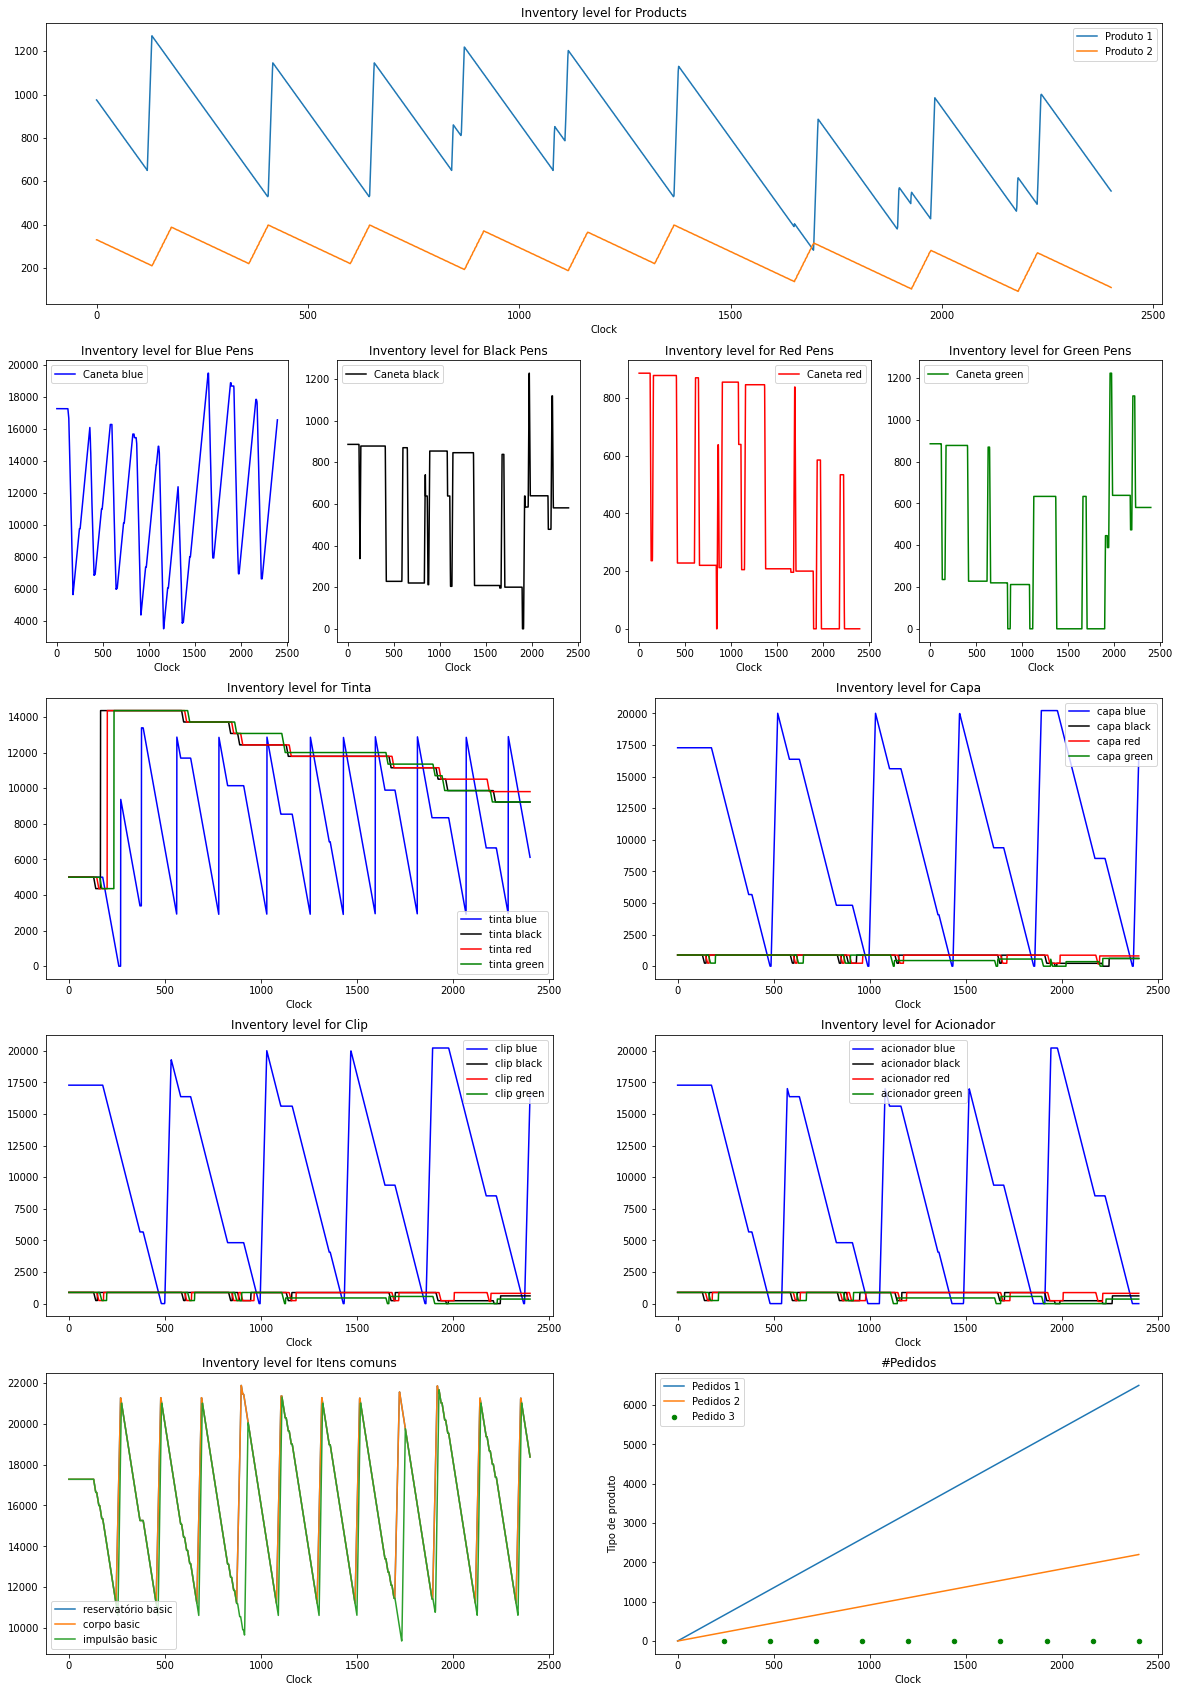

In [9]:
fator_stock = 1
fator_demanda_prod = 1
injetoras = [2, 128, 60000]
montadoras = 1
random_state = 0
days = 5

simulation_config, centers_info, cost_estoques, cost_rent = set_config(fator_stock, fator_demanda_prod, injetoras, montadoras, random_state, days)

factory_results, df_stocks, df_demand, cost = simulation(simulation_config, centers_info, cost_estoques, cost_rent)

## **4) Testando cenários**

### **4.1) Definindo cenários e fatores**

In [156]:
fatores_config = {'fator_1': {1: 1, 2: 2, 3: 3, 4: 4},  ## Número de injetoras
                  'fator_2': {1: [64, 30000], 2: [128, 60000], 3: [256, 120000]},   ## Tipo de injetora
                  'fator_3': {1: 1, 2: 2, 3: 3},    ## Número de montadoras
                  'fator_4': {1: 45, 2: 90, 3: 135, 4: 180},    ## Estoque de componentes/canetas
                  'fator_5': {1: 0.5, 2: 1, 3: 1.5}     ## Estoque de produtos
                  }

base_scenarios = {'s1': {'fator_1': 2, 'fator_2': 2, 'fator_3': 1},
                  's2': {'fator_1': 1, 'fator_2': 3, 'fator_3': 1},
                  's3': {'fator_1': 4, 'fator_2': 1, 'fator_3': 1},
                  's4': {'fator_1': 1, 'fator_2': 2, 'fator_3': 1},
                  's5': {'fator_1': 2, 'fator_2': 1, 'fator_3': 1},
                  's6': {'fator_1': 3, 'fator_2': 1, 'fator_3': 1},
                  's7': {'fator_1': 1, 'fator_2': 2, 'fator_3': 2},
                  's8': {'fator_1': 2, 'fator_2': 1, 'fator_3': 2},
                  's9': {'fator_1': 3, 'fator_2': 1, 'fator_3': 2},
                  's10': {'fator_1': 1, 'fator_2': 2, 'fator_3': 3},
                  's11': {'fator_1': 2, 'fator_2': 1, 'fator_3': 3},
                  's12': {'fator_1': 3, 'fator_2': 1, 'fator_3': 3}
                  }



### **4.2) Definindo funções**

In [164]:
def define_scenarios(base_scenarios, fatores_config):
    scenario_config = {}
    test = []
    id_scenario = 1
    for base_scenario in base_scenarios:
        scenario = base_scenarios[base_scenario]
        for level_4 in fatores_config['fator_4']:
            scenario['fator_4'] = level_4
            for level_5 in fatores_config['fator_5']:
                scenario['fator_5'] = level_5
                a = scenario.copy()
                scenario_config[id_scenario] = a
                id_scenario += 1
    
    return scenario_config              

##### =============================================    

def build_scenario(stock_config1, machines_config, scenarios_config, fatores_config, id_experiment):
    '''
    
    Input: dict, dict, dict, dict, Int
    Output: dict, dict, Int
    Descripton: This functions receives the scenarios to be simulated and the ID of the current experiment and sets up 
    the simulation parameters

    '''
    ## Fator 1 (Quantidade de injetoras)
    machines_config['injetora']['qty'] =  fatores_config['fator_1'][scenarios_config[id_experiment]['fator_1']]

    ## Fator 2 (Capacidade das injetoras)
    machines_config['injetora']['lot_size'] = fatores_config['fator_2'][scenarios_config[id_experiment]['fator_2']][0]
    machines_config['injetora']['cost'] = fatores_config['fator_2'][scenarios_config[id_experiment]['fator_2']][1]
    
    ## Fator 3 (Quantidade de montadoras)
    machines_config['montagem']['qty'] =  fatores_config['fator_3'][scenarios_config[id_experiment]['fator_3']]
    
    ## Fator 4 (Estoque de componentes)
    fator_stock = fatores_config['fator_4'][scenarios_config[id_experiment]['fator_4']]
    
    ## Fator 5 (Estoque de produtos)
    fator_demanda_prod = fatores_config['fator_5'][scenarios_config[id_experiment]['fator_5']]

    stock_config = {'blue': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                    'black, red and green': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                    
                    'components with color': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                    'components basic': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                    
                    'produto 1': {'Smin': int(fator_demanda_prod*6500/5/2), 'Smax': int(fator_demanda_prod*6500/5), 'initial_stock':int(fator_demanda_prod*6500/5*3/4)},
                    'produto 2': {'Smin': int(fator_demanda_prod*2200/5/2), 'Smax': int(fator_demanda_prod*2200/5), 'initial_stock': int(fator_demanda_prod*2200/5*3/4)},
                    'cost_stock': 1,
                    'cost_rupture': stock_config1['cost_rupture'],
                    'random_state': 1,
                    'days': 5
                    }
     ## Defines the Rent cost based on the parameters chosen
    if fator_stock + fator_demanda_prod < 136:
        cost_rent = 10000
    elif fator_stock + fator_demanda_prod < 181:
        cost_rent = 15000
    else:
        cost_rent = 20000
    
    return stock_config, machines_config, cost_rent

##### =============================================

def simulation_experiment(config, config_machines, id_experiment, repeticao, path, config_cost_stock, cost_rent, fatores):
    '''
    
    Input: dict, dict
    Output: Object, pd.DataFrame, pd.DataFrame, float
    Descripton: This functions receives the simulation parameters of the experiment and runs the simulation in the Simpy environment.
    In the end, it computes the costs of the configuration and saves the main results of the simulation (plots and csv's files)

    '''
    
    experiment_config = {}
    
    days = config['days']
    simulation_time = int(days*8*60)    # minutes
    
    ## Setup of the 'Factory' and the simulation environment
    env, factory = problem(config, config_machines)
    
    ## Creates the sales module for the simulation
    sales_process = env.process(sales_module(env, factory))
    
    ## Runs the simulation
    env.run(simulation_time)
    
    ## Computes the service rate and stock-out cost
    nb_rupturas = 0
    cost = 0
    lucro_ = 0
    
    for product in factory.demand:
        if product != 3:
            experiment_config['Produto_' + str(product) + '_service'] = factory.sales[product]/factory.demand[product]*100   
            cost += (factory.demand[product] - factory.sales[product])*config['cost_rupture']
            nb_rupturas += factory.demand[product] -  factory.sales[product] 
            lucro_ += factory.sales[product]*factory.info['product'][product]['margin']
        
    cost_ruptura = nb_rupturas*config['cost_rupture']
    # print('Número vendas perdidas: %i' %(nb_rupturas))
        
    
    def plot_results_experiment(factory_results, id_experiment, repeticao, path, fatores):
        '''
    
        Input: Object, Int, Int, str, dict
        Output: pd.DataFrame, pd.DataFrame
        Descripton: This functions receives the simulated factory Object, stocks the data in two pandas' Dataframes and then plots 
        the results 
    
        '''
        df_stocks = pd.DataFrame(data = factory_results.data_monitor, columns= factory_results.columns_monitor)

        # df_stocks

        df_demand = pd.DataFrame(data = factory_results.data_demand, columns = ['Clock', 'Tipo de produto'])
        df_demand.fillna(0)
        df_demand['Counter'] = df_demand.groupby(['Tipo de produto']).cumcount()+1
            
        df_demand['Pedidos 1'] = np.where(df_demand['Tipo de produto'] == 1, 1, 0 )
        df_demand['Pedidos 1'] = df_demand['Pedidos 1'].cumsum()

        df_demand['Pedidos 2'] = np.where(df_demand['Tipo de produto'] == 2, 1, 0 )
        df_demand['Pedidos 2'] = df_demand['Pedidos 2'].cumsum()

        df_demand['Pedidos 3'] = np.where(df_demand['Tipo de produto'] == 3, 1, 0 )
        df_demand['Pedidos 3'] = df_demand['Pedidos 3'].cumsum()

        # df_demand

        fig = plt.figure(figsize=(20, 30))
        
        fig.suptitle(fatores)

        n_rows = 5
        n_columns = 2

        ax1 = fig.add_subplot(n_rows, n_columns, (1,2))
        ax1.set_title('Inventory level for Products')
        df_stocks.plot(x =  "Clock", y = "Produto 1", ax=ax1)
        df_stocks.plot(x =  "Clock", y = "Produto 2", ax=ax1)

        ax2a = fig.add_subplot(n_rows, n_columns*2, (5,5))
        ax2b = fig.add_subplot(n_rows, n_columns*2, (6,6))
        ax2c = fig.add_subplot(n_rows, n_columns*2, (7,7))
        ax2d = fig.add_subplot(n_rows, n_columns*2, (8,8))
        ax2a.set_title('Inventory level for Blue Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta blue", ax=ax2a, color = 'Blue')
        ax2b.set_title('Inventory level for Black Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta black", ax=ax2b, color = 'Black')
        ax2c.set_title('Inventory level for Red Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta red", ax=ax2c, color = 'Red')
        ax2d.set_title('Inventory level for Green Pens')
        df_stocks.plot(x =  "Clock", y = "Caneta green", ax=ax2d, color = 'Green')

        ax3 = fig.add_subplot(n_rows, n_columns, (5,5))
        ax3.set_title('Inventory level for Tinta')
        df_stocks.plot(x =  "Clock", y = "tinta blue", ax=ax3, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "tinta black", ax=ax3, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "tinta red", ax=ax3, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "tinta green", ax=ax3, color = 'Green')

        ax4 = fig.add_subplot(n_rows, n_columns, (6,6))
        ax4.set_title('Inventory level for Capa')
        df_stocks.plot(x =  "Clock", y = "capa blue", ax=ax4, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "capa black", ax=ax4, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "capa red", ax=ax4, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "capa green", ax=ax4, color = 'Green')

        ax5 = fig.add_subplot(n_rows, n_columns, (7,7))
        ax5.set_title('Inventory level for Clip')
        df_stocks.plot(x =  "Clock", y = "clip blue", ax=ax5, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "clip black", ax=ax5, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "clip red", ax=ax5, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "clip green", ax=ax5, color = 'Green')

        ax6 = fig.add_subplot(n_rows, n_columns, (8,8))
        ax6.set_title('Inventory level for Acionador')
        df_stocks.plot(x =  "Clock", y = "acionador blue", ax=ax6, color = 'Blue')
        df_stocks.plot(x =  "Clock", y = "acionador black", ax=ax6, color = 'Black')
        df_stocks.plot(x =  "Clock", y = "acionador red", ax=ax6, color = 'Red')
        df_stocks.plot(x =  "Clock", y = "acionador green", ax=ax6, color = 'Green')

        ax7 = fig.add_subplot(n_rows, n_columns, (9,9))
        ax7.set_title('Inventory level for Itens comuns')
        df_stocks.plot(x =  "Clock", y = "reservatório basic", ax=ax7)
        df_stocks.plot(x =  "Clock", y = "corpo basic", ax=ax7)
        df_stocks.plot(x =  "Clock", y = "impulsão basic", ax=ax7)

        ax8 = fig.add_subplot(n_rows, n_columns, (10,10))
        ax8.set_title('#Pedidos')
        df_demand.plot(x =  "Clock", y = "Pedidos 1", ax=ax8)
        df_demand.plot(x =  "Clock", y = "Pedidos 2", ax=ax8)
        # df_demand.plot(x =  "Clock", y = "Pedidos 3", ax=ax8)
        df_demand.loc[df_demand['Tipo de produto'] == 3].plot.scatter(x =  "Clock", y = "Tipo de produto", ax=ax8, color = 'green', label = 'Pedido 3')
        
        name = path + '/Scenario_' + str(id_experiment) + '_' + str(repeticao) + '_plot.png'
        plt.savefig(name)
        plt.close()
    
        return df_stocks, df_demand

    ## Plots the main results
    df_stocks, df_demand = plot_results_experiment(factory, id_experiment, repeticao, path, fatores)        
    

    ## Computes the stock cost
    df_mean_stocks = df_stocks.mean()
    df_mean_stocks = df_mean_stocks.drop(labels = ['Clock', 'ponta_esfera_mola basic'])
    
    cost_stock = 0
    for item in df_mean_stocks.items():
        if "tinta" in item[0]:
            cost_stock += config_cost_stock[item[0]]
        else:
            cost_stock += item[1]*config_cost_stock[item[0]]
        
    cost += cost_stock
    
    cost_machine = 0
    for machine in config_machines:
        cost_machine += config_machines[machine]['qty']*config_machines[machine]['cost']
    
    cost += cost_machine
    cost += cost_rent
    
    factory.cost = [cost, cost_machine, cost_stock, cost_ruptura]
    
    experiment_config['cost_machine'] = cost_machine
    experiment_config['cost_stock'] = cost_stock
    experiment_config['cost_rupture'] = cost_ruptura
    experiment_config['cost_rent'] = cost_rent
    experiment_config['cost_total'] = cost
    # experiment_config['lucro'] = lucro_
    
    
    
    print('Experimento #%i (%i) finalizado' %(id_experiment, (repeticao+1)))  
        
    return experiment_config, df_stocks

##### =============================================

def run_experiments(base_scenarios, fatores_config, n):
    '''
    
    Input: dict, dict, Int
    Output: Object, pd.DataFrame, pd.DataFrame, float
    Descripton: This functions receives the scenarios to be simulated and the number of repetitions. It creates a folder
    in which the experiments' results will be saved.

    '''
    
    scenarios_config = define_scenarios(base_scenarios, fatores_config) 
    
    ## Creates the folder in which the results will be saved
    import os
    path = 'experiments0'
    if not os.path.exists('experiments0'):
        os.makedirs('experiments0')
    else:
        i = 1
        created = False
        while not created:
            if not os.path.exists('experiments' + str(i)):
                os.makedirs('experiments' + str(i))
                created = True
                path = 'experiments' + str(i)
            else:
                i+= 1
                
    print('Pasta criada: %s' %(path))
    print('Total simulations = %i (%i x %i)' %(len(scenarios_config)*n, len(scenarios_config), n ))
    
    ## Creates the basic structure of the simulation parameters
    cost_estoques = {'Produto 1': 1,
                    'Produto 2': 1,
                    'Produto 3': 1,
                    'Caneta blue': 0.5,
                    'Caneta black': 0.5,
                    'Caneta red': 0.5,
                    'Caneta green': 0.5,
                    'tinta blue': 300,
                    'tinta black': 300,
                    'tinta red': 300,
                    'tinta green': 300,
                    'capa blue': 0.1,
                    'capa black': 0.1,
                    'capa red': 0.1,
                    'capa green': 0.1,
                    'clip blue': 0.1,
                    'clip black': 0.1,
                    'clip red': 0.1,
                    'clip green': 0.1,
                    'acionador blue': 0.1,
                    'acionador black': 0.1,
                    'acionador red': 0.1,
                    'acionador green': 0.1,
                    'reservatório basic': 0.1,
                    'corpo basic': 0.1,
                    'impulsão basic': 0.1}
        
    centers_info = {'mixer': {'qty': 1, 'time': 30, 'lot_size': int(20*1000/2), 'setup': 5, 'cost': 5000}, 
                'injetora': {'qty': 2, 'time': 12/60, 'lot_size': 128, 'setup': 15, 'cost': 6000},
                'extrusora': {'qty': 1, 'time': 1/60, 'lot_size': 8, 'setup': 5, 'cost': 30000},
                'bobinadora': {'qty': 1, 'time': 1/60, 'lot_size': 8, 'setup': 5, 'cost': 20000}, 
                'montagem': {'qty': 1, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 10000},
                'embalagem': {'qty': 4, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 2500},
                'impressora': {'qty': 1, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 5000}}
    
    fator_stock = 180
    fator_demanda_prod1 = 1*6500/5
    fator_demanda_prod2 = 1*2200/5

    simulation_config = {'blue': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                        'black, red and green': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                        
                        'components with color': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                        'components basic': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                        
                        'produto 1': {'Smin': int(fator_demanda_prod1/2), 'Smax': int(fator_demanda_prod1), 'initial_stock':int(fator_demanda_prod1*3/4)},
                        'produto 2': {'Smin': int(fator_demanda_prod2/2), 'Smax': int(fator_demanda_prod2), 'initial_stock': int(fator_demanda_prod2*3/4)},
                        'cost_stock': 1,
                        'cost_rupture': 30,
                        'random_state': 0,
                        'days': 5
                        }
    
    ## Simulates each scenario 'n' times
    results = []
    repeat = n
    for scenario in scenarios_config:
        stock_config, machines_config, cost_rent = build_scenario(simulation_config, centers_info, scenarios_config, fatores_config, scenario)
        for i in range(repeat):
            experiment, df_stocks = simulation_experiment(stock_config, machines_config, scenario, i, path,cost_estoques, cost_rent, scenarios_config[scenario])
            results.append(experiment)
        
    ## Treats the results
    df_experiments = pd.DataFrame(results).round(2)
    df_scenario = pd.DataFrame.from_dict(scenarios_config, orient = 'index')
    df_scenario = pd.DataFrame(np.repeat(df_scenario.values, n, axis=0), columns=df_scenario.columns)

    df_new = pd.concat([df_scenario, df_experiments.reindex(df_scenario.index)], axis=1)
    df_new.sort_values(by=['cost_total'], inplace=True)
    df_new['cost_total'] = df_new['cost_total']
    df_new['fator_2'] = df_new['fator_2'].astype(str)
    
    df_test = df_new.groupby(by = ['fator_1', 'fator_2', 'fator_3', 'fator_4','fator_5'])[['Produto_1_service', 'Produto_2_service', 'cost_total', 'cost_machine','cost_rent', 'cost_stock','cost_rupture']].mean().round(2)
    df_test['cost_op'] =  (df_test['cost_stock'] +  df_test['cost_rupture'] + df_test['cost_rent']).round(2)
    
    df_test.sort_values(by=['cost_total'], inplace=True)
    
    ## Saves the results in a CSV file
    df_new.to_csv(path + '/Resultados_experimentos.csv')
    df_test.to_csv(path + '/mean_results.csv')
    
    print('====== FIM ======')
    
    return df_new, df_test, df_stocks
        


### **4.3) Executando experimentos com os cenários**

Na célula abaixo, escolha o número de repetições a serem simuladas para cada cenários:
* **n**: $\in$ $\mathbb{N^*}$
  * Número de repetições para cada cenário simulado

In [165]:
n = 3
df_experiments, df_mean, df_stocks = run_experiments(base_scenarios, fatores_config, n)

Pasta criada: experiments3
Total simulations = 432 (144 x 3)
Experimento #1 (1) finalizado
Experimento #1 (2) finalizado
Experimento #1 (3) finalizado
Experimento #2 (1) finalizado
Experimento #2 (2) finalizado
Experimento #2 (3) finalizado
Experimento #3 (1) finalizado
Experimento #3 (2) finalizado
Experimento #3 (3) finalizado
Experimento #4 (1) finalizado
Experimento #4 (2) finalizado
Experimento #4 (3) finalizado
Experimento #5 (1) finalizado
Experimento #5 (2) finalizado
Experimento #5 (3) finalizado
Experimento #6 (1) finalizado
Experimento #6 (2) finalizado
Experimento #6 (3) finalizado
Experimento #7 (1) finalizado
Experimento #7 (2) finalizado
Experimento #7 (3) finalizado
Experimento #8 (1) finalizado
Experimento #8 (2) finalizado
Experimento #8 (3) finalizado
Experimento #9 (1) finalizado
Experimento #9 (2) finalizado
Experimento #9 (3) finalizado
Experimento #10 (1) finalizado
Experimento #10 (2) finalizado
Experimento #10 (3) finalizado
Experimento #11 (1) finalizado
Exper

Seleção dos 10 melhores cenários (por custo operacional)

In [187]:
best_10 = {1: {'fator_1': 2, 'fator_2': 1, 'fator_3': 3, 'fator_4': 1, 'fator_5': 1},
           2: {'fator_1': 1, 'fator_2': 2, 'fator_3': 3, 'fator_4': 1, 'fator_5': 1},
           3: {'fator_1': 3, 'fator_2': 1, 'fator_3': 3, 'fator_4': 1, 'fator_5': 1},
           4: {'fator_1': 1, 'fator_2': 2, 'fator_3': 2, 'fator_4': 2, 'fator_5': 1},
           5: {'fator_1': 1, 'fator_2': 2, 'fator_3': 3, 'fator_4': 2, 'fator_5': 1},
           6: {'fator_1': 1, 'fator_2': 2, 'fator_3': 2, 'fator_4': 2, 'fator_5': 2},
           7: {'fator_1': 1, 'fator_2': 2, 'fator_3': 3, 'fator_4': 2, 'fator_5': 2},
           8: {'fator_1': 2, 'fator_2': 1, 'fator_3': 3, 'fator_4': 2, 'fator_5': 1},
           9: {'fator_1': 2, 'fator_2': 1, 'fator_3': 2, 'fator_4': 2, 'fator_5': 1},
           10: {'fator_1': 2, 'fator_2': 1, 'fator_3': 2, 'fator_4': 2, 'fator_5': 2}
            }

In [195]:
def run_best_experiments(scenarios_config, n):
    '''
    
    Input: dict, dict, Int
    Output: Object, pd.DataFrame, pd.DataFrame, float
    Descripton: This functions receives the best scenarios to be simulated and the number of repetitions. It creates a folder
    in which the experiments' results will be saved.

    '''
    
    ## Creates the folder in which the results will be saved
    import os
    path = 'experiments0'
    if not os.path.exists('experiments0'):
        os.makedirs('experiments0')
    else:
        i = 1
        created = False
        while not created:
            if not os.path.exists('experiments' + str(i)):
                os.makedirs('experiments' + str(i))
                created = True
                path = 'experiments' + str(i)
            else:
                i+= 1
                
    print('Pasta criada: %s' %(path))
    print('Total simulations = %i (%i x %i)' %(len(scenarios_config)*n, len(scenarios_config), n ))
    
    ## Creates the basic structure of the simulation parameters
    cost_estoques = {'Produto 1': 1,
                    'Produto 2': 1,
                    'Produto 3': 1,
                    'Caneta blue': 0.5,
                    'Caneta black': 0.5,
                    'Caneta red': 0.5,
                    'Caneta green': 0.5,
                    'tinta blue': 300,
                    'tinta black': 300,
                    'tinta red': 300,
                    'tinta green': 300,
                    'capa blue': 0.1,
                    'capa black': 0.1,
                    'capa red': 0.1,
                    'capa green': 0.1,
                    'clip blue': 0.1,
                    'clip black': 0.1,
                    'clip red': 0.1,
                    'clip green': 0.1,
                    'acionador blue': 0.1,
                    'acionador black': 0.1,
                    'acionador red': 0.1,
                    'acionador green': 0.1,
                    'reservatório basic': 0.1,
                    'corpo basic': 0.1,
                    'impulsão basic': 0.1}
        
    centers_info = {'mixer': {'qty': 1, 'time': 30, 'lot_size': int(20*1000/2), 'setup': 5, 'cost': 5000}, 
                'injetora': {'qty': 2, 'time': 12/60, 'lot_size': 128, 'setup': 15, 'cost': 6000},
                'extrusora': {'qty': 1, 'time': 1/60, 'lot_size': 8, 'setup': 5, 'cost': 30000},
                'bobinadora': {'qty': 1, 'time': 1/60, 'lot_size': 8, 'setup': 5, 'cost': 20000}, 
                'montagem': {'qty': 1, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 10000},
                'embalagem': {'qty': 4, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 2500},
                'impressora': {'qty': 1, 'time': 1/60, 'lot_size': 1, 'setup': 5, 'cost': 5000}}
    
    fator_stock = 180
    fator_demanda_prod1 = 1*6500/5
    fator_demanda_prod2 = 1*2200/5

    simulation_config = {'blue': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                        'black, red and green': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                        
                        'components with color': {'Smin': int(128*fator_stock/36), 'Smax': int(128*fator_stock/18), 'initial_stock': int(128*fator_stock/26)},
                        'components basic': {'Smin': int(128*fator_stock/2), 'Smax': int(128*fator_stock), 'initial_stock': int(128*3*fator_stock/4)},
                        
                        'produto 1': {'Smin': int(fator_demanda_prod1/2), 'Smax': int(fator_demanda_prod1), 'initial_stock':int(fator_demanda_prod1*3/4)},
                        'produto 2': {'Smin': int(fator_demanda_prod2/2), 'Smax': int(fator_demanda_prod2), 'initial_stock': int(fator_demanda_prod2*3/4)},
                        'cost_stock': 1,
                        'cost_rupture': 30,
                        'random_state': 0,
                        'days': 5
                        }
    
    ## Simulates each scenario 'n' times
    results = []
    repeat = n
    for scenario in scenarios_config:
        stock_config, machines_config, cost_rent = build_scenario(simulation_config, centers_info, scenarios_config, fatores_config, scenario)
        for i in range(repeat):
            experiment, df_stocks = simulation_experiment(stock_config, machines_config, scenario, i, path,cost_estoques, cost_rent, scenarios_config[scenario])
            results.append(experiment)
        
    ## Treats the results
    df_experiments = pd.DataFrame(results).round(2)
    df_scenario = pd.DataFrame.from_dict(scenarios_config, orient = 'index')
    df_scenario = pd.DataFrame(np.repeat(df_scenario.values, n, axis=0), columns=df_scenario.columns)

    df_new = pd.concat([df_scenario, df_experiments.reindex(df_scenario.index)], axis=1)
    df_new.sort_values(by=['cost_total'], inplace=True)
    df_new['cost_total'] = df_new['cost_total']
    df_new['fator_2'] = df_new['fator_2'].astype(str)
    
    df_test = df_new.groupby(by = ['fator_1', 'fator_2', 'fator_3', 'fator_4','fator_5'])[['Produto_1_service', 'Produto_2_service', 'cost_total', 'cost_machine','cost_rent', 'cost_stock','cost_rupture']].mean().round(2)
    df_test['cost_op'] =  (df_test['cost_stock'] +  df_test['cost_rupture'] + df_test['cost_rent']).round(2)
    
    df_test.sort_values(by=['cost_total'], inplace=True)
    
    ## Saves the results in a CSV file
    df_new.to_csv(path + '/Resultados_experimentos.csv')
    df_test.to_csv(path + '/mean_results.csv')
    
    print('====== FIM ======')
    
    return df_new, df_test, df_stocks
    


Na célula abaixo, escolha o número de repetições a serem simuladas para cada um dos melhores cenários:
* **n**: $\in$ $\mathbb{N^*}$
  * Número de repetições para cada cenário simulado

In [189]:
n = 10
df_experiments_best, df_mean_best, df_stock_best = run_best_experiments(best_10, n)

Pasta criada: experiments4
Total simulations = 100 (10 x 10)
Experimento #1 (1) finalizado
Experimento #1 (2) finalizado
Experimento #1 (3) finalizado
Experimento #1 (4) finalizado
Experimento #1 (5) finalizado
Experimento #1 (6) finalizado
Experimento #1 (7) finalizado
Experimento #1 (8) finalizado
Experimento #1 (9) finalizado
Experimento #1 (10) finalizado
Experimento #2 (1) finalizado
Experimento #2 (2) finalizado
Experimento #2 (3) finalizado
Experimento #2 (4) finalizado
Experimento #2 (5) finalizado
Experimento #2 (6) finalizado
Experimento #2 (7) finalizado
Experimento #2 (8) finalizado
Experimento #2 (9) finalizado
Experimento #2 (10) finalizado
Experimento #3 (1) finalizado
Experimento #3 (2) finalizado
Experimento #3 (3) finalizado
Experimento #3 (4) finalizado
Experimento #3 (5) finalizado
Experimento #3 (6) finalizado
Experimento #3 (7) finalizado
Experimento #3 (8) finalizado
Experimento #3 (9) finalizado
Experimento #3 (10) finalizado
Experimento #4 (1) finalizado
Experi